<a href="https://colab.research.google.com/github/monahashemiii/QNN/blob/main/Sample_HQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Python Script Scaffolding

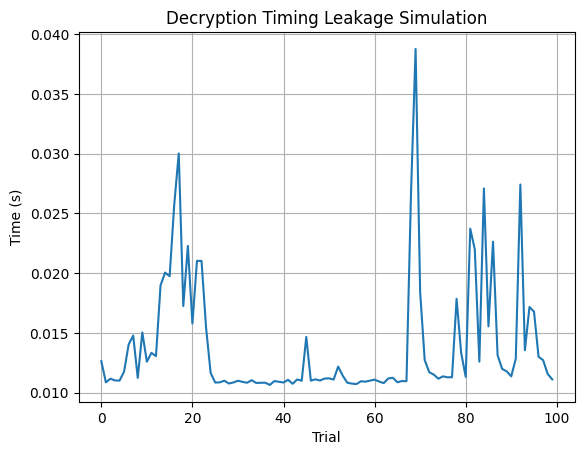

In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt

# --- Placeholder for HQC crypto lib ---
# In real use, replace these with pyHQC
def hqc_keygen():
    sk = np.random.randint(2, size=512)  # Secret key
    pk = np.random.randint(2, size=512)  # Public key
    return pk, sk

def hqc_encrypt(pk, message):
    # Fake encryption for illustration
    ciphertext = np.bitwise_xor(pk[:len(message)], message)
    return ciphertext

def hqc_decrypt(sk, ciphertext):
    # Fake decryption with artificial timing
    result = []
    start = time.perf_counter()
    for i, bit in enumerate(ciphertext):
        # simulate delay based on secret key bit (for timing leakage)
        if sk[i % len(sk)] == 1:
            time.sleep(0.0001)  # artificial timing delay
        result.append(bit ^ sk[i % len(sk)])
    end = time.perf_counter()
    return np.array(result), end - start

# --- Fake input generation ---
def generate_random_message(length=128):
    return np.random.randint(2, size=length)

# --- Simulated measurement run ---
def test_decryption_timing(num_tests=100):
    pk, sk = hqc_keygen()
    timings = []
    for _ in range(num_tests):
        msg = generate_random_message()
        ct = hqc_encrypt(pk, msg)
        _, t = hqc_decrypt(sk, ct)
        timings.append(t)
    return timings

if __name__ == "__main__":
    timing_data = test_decryption_timing(100)
    plt.plot(timing_data)
    plt.title("Decryption Timing Leakage Simulation")
    plt.xlabel("Trial")
    plt.ylabel("Time (s)")
    plt.grid(True)
    plt.show()

# 2. Fake Leakage & Benchmarking Dataset

In [2]:
def simulate_hw_leakage(intermediate):
    return bin(intermediate).count('1') + np.random.normal(0, 0.5)

def collect_fake_leakage_samples(num_samples=1000):
    leakage = []
    labels = []
    sk = np.random.randint(2, size=128)  # assume small secret
    for _ in range(num_samples):
        msg = generate_random_message(128)
        intermediate = msg ^ sk  # artificial 'sensitive operation'
        hw_trace = [simulate_hw_leakage(x) for x in intermediate]
        leakage.append(hw_trace)
        labels.append(sk)  # optional for training
    return np.array(leakage), np.array(labels)

# 3. Updated HQC-style Decryption with Leakage

In [3]:
import numpy as np
import time

# --- Fake KeyGen & Encrypt ---
def hqc_keygen(n=256):
    sk = np.random.randint(2, size=n)
    pk = np.random.randint(2, size=n)
    return pk, sk

def hqc_encrypt(pk, msg):
    # Simulated encryption: XOR for placeholder
    return np.bitwise_xor(pk[:len(msg)], msg)

# --- Decryption with simulated leakage ---
def hqc_decrypt_leaky(sk, ciphertext, leak_model='timing'):
    recovered = []
    trace = []
    start = time.perf_counter()

    for i in range(len(ciphertext)):
        sk_bit = sk[i % len(sk)]
        ct_bit = ciphertext[i]

        if leak_model == 'timing':
            # Simulate timing leakage: longer if key bit is 1
            delay = 0.0001 if sk_bit == 1 else 0.00005
            time.sleep(delay)
            trace.append(delay)

        elif leak_model == 'hw':
            # Simulate Hamming weight leakage (HW of ct_bit ^ sk_bit)
            hw = bin(ct_bit ^ sk_bit).count('1') + np.random.normal(0, 0.2)
            trace.append(hw)

        result = ct_bit ^ sk_bit
        recovered.append(result)

    end = time.perf_counter()
    total_time = end - start

    return np.array(recovered), trace, total_time

# 4. Example Attack Flow

<function matplotlib.pyplot.show(close=None, block=None)>

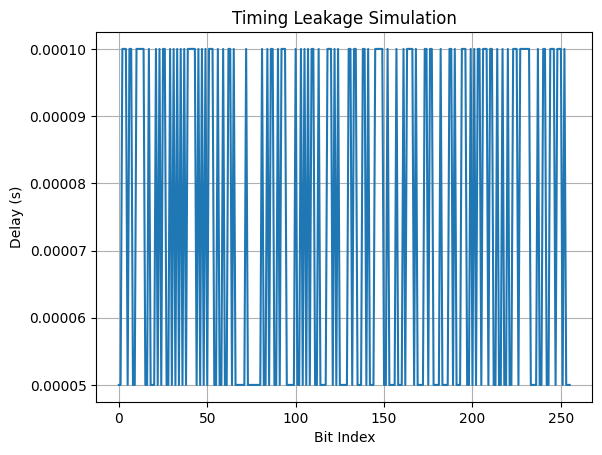

In [8]:
pk, sk = hqc_keygen()
msg = np.random.randint(2, size=256)
ct = hqc_encrypt(pk, msg)

# Simulate timing leakage
_, trace, total = hqc_decrypt_leaky(sk, ct, leak_model='timing')

# Now: analyze `trace` or `total` to recover parts of `sk`
plt.plot(trace)
plt.title("Timing Leakage Simulation")
plt.xlabel("Bit Index")
plt.ylabel("Delay (s)")
plt.grid(True)
plt.show
#

In [9]:
import ctypes
import os
import numpy as np

# Load the shared library
lib = ctypes.CDLL("./libhqc.so")

# PQClean API: int crypto_kem_keypair(uint8_t *pk, uint8_t *sk);
CRYPTO_PUBLICKEYBYTES = 2249
CRYPTO_SECRETKEYBYTES = 4522
CRYPTO_CIPHERTEXTBYTES = 4481
CRYPTO_BYTES = 32

# Allocate buffers
pk = (ctypes.c_uint8 * CRYPTO_PUBLICKEYBYTES)()
sk = (ctypes.c_uint8 * CRYPTO_SECRETKEYBYTES)()
ct = (ctypes.c_uint8 * CRYPTO_CIPHERTEXTBYTES)()
ss_enc = (ctypes.c_uint8 * CRYPTO_BYTES)()
ss_dec = (ctypes.c_uint8 * CRYPTO_BYTES)()

# Run keypair
lib.crypto_kem_keypair(pk, sk)

# Encapsulation
lib.crypto_kem_enc(ct, ss_enc, pk)

# Decapsulation
lib.crypto_kem_dec(ss_dec, ct, sk)

# Compare shared secrets
print("Shared secrets match?", list(ss_enc) == list(ss_dec))

OSError: ./libhqc.so: cannot open shared object file: No such file or directory